# Visualizing MDS189

In this notebook, we will walk through some visualizations for the MDS 189 dataset. MDS 189 has the following structure:

In [1]:
import json
import glob
# Note that if your imageio fails for whatever reason, you can replace it with another package for loading images, e.g., opencv
import imageio 
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import numpy as np
import pdb
%matplotlib inline

# Setup MDS189 directory structure
You will need to update the rootdir location. Everything else should remain unchanged.

In [40]:
rootdir = './mds189/trainval' ## TODO: Update this!
mds_dirs = {'root': rootdir,
            'labels': '{}/{}/labels'.format(rootdir,'{}'),
            'keyframes': '{}/{}/key_frames'.format(rootdir,'{}'),
            'frames': '{}/{}/frames'.format(rootdir,'{}'),
            'resized': '{}/{}/key_frames_resized'.format(rootdir,'{}')
           }

# Helper functions

First we setup a lot of helper functions for the visualization. Run the next cell, and move on to the key frames visualization cell.

In [41]:
def get_all_label_combos(num_labels):
    '''
    Later, when we want to visualize all key frames, we conveniently have their label 
    types and corresponding sides for all possible combinations for the 13 key frames.
    '''
    if num_labels == 13:
        all_labels = ['reach','squat','inline','inline','lunge',
                      'lunge','hamstrings','hamstrings','stretch',
                      'stretch','deadbug','deadbug','pushup'
                     ]
        all_sides = ['both','both','left','right','left','right',
                     'left','right','left','right','left','right','both']
    elif num_labels == 8:
        all_labels = ['reach','squat','inline','lunge','hamstrings',
                      'stretch','deadbug','pushup'
                     ]
        all_sides = None # when we're oinly doing 8 movements, we don't care about the side
    else:
        raise ValueError('num_labels can only be 13 or 8')
    return len(all_labels),all_labels,all_sides

def get_labelbox_colormap():
    '''
    Returns the color map that gives the color for each keypoint. 
    These colors are meant to mimick the colors you saw in labelbox.
    '''
    colormap = {
        'Nose': (1,0,0),       # red
        'Neck': (1,0,0),
        'LShoulder': (0,1,0),  # green
        'LElbow': (0,1,0),
        'LWrist': (0,1,0),
        'LHip': (0,0,1),       # blue
        'LKnee': (0,0,1),
        'LAnkle': (0,0,1),
        'LHeel': (0,1,1),      # cyan
        'LBigToe': (0,1,1),
        'LSmallToe': (0,1,1),
        'LEye': (1,1,1),       # white
        'LEar': (1,1,1),
        'MidHip': (1,0,0),     # red
        'REye': (0.5,0.5,0.5), # gray
        'REar': (0.5,0.5,0.5),
        'RShoulder': (1,165/255.,0),      # orange
        'RElbow': (1,165/255.,0),
        'RWrist': (1,165/255.,0),
        'RHip': (128/255.,0,128/255.),    # purple
        'RKnee': (128/255.,0,128/255.),
        'RAnkle': (128/255.,0,128/255.),
        'RHeel': (1,0,1),                 # magenta
        'RBigToe': (1,0,1),
        'RSmallToe': (1,0,1)
    }
    return colormap

def get_openpose_dict(op_kps):
    keypoints_map_list = ['Nose',
                          'Neck',
                          'RShoulder',
                          'RElbow',
                          'RWrist',
                          'LShoulder',
                          'LElbow',
                          'LWrist',
                          'MidHip',
                          'RHip',
                          'RKnee',
                          'RAnkle',
                          'LHip',
                          'LKnee',
                          'LAnkle',
                          'REye',
                          'LEye',
                          'REar',
                          'LEar',
                          'LBigToe',
                          'LSmallToe',
                          'LHeel',
                          'RBigToe',
                          'RSmallToe',
                          'RHeel']
    kps_op_dict = {}
    kps_arr = np.reshape(np.array(op_kps),(25,3))
    for (dict_key,kps) in zip(keypoints_map_list,kps_arr):
        kps_op_dict[dict_key] = {'x':kps[0],'y':kps[1],'logits':kps[2]}
    return kps_op_dict

def read_json(filename):
    '''Convenience wrapper for reading json files.'''   
    with open(filename,'r') as f:
        data = json.load(f)
    return data

## Universal helper functions
def get_random_subject(rootdir,subject_idx=None):
    '''
    Unless you specify a subject index, returns random selection from all possibilities.
    Returns
     - subject_idx \in range(300)
    '''
    _,subjects,_ = os.walk(rootdir).next()
    subjects = sorted(subjects)
    if subject_idx is not None:
        return subject_idx #subjects[subject_idx]
    else:
        return random.choice(subjects)

def get_random_label(label_type):
    '''
    Unless you specify a label, returns random selection from list of labels.
    Returns
     - label_type \in {None,'reach','squat','lunge','inline','hamstrings','deadbug','stretch','pushup'}
    '''
    if label_type is not None:
        return label_type
    else:
        return random.choice(['reach','squat','lunge','inline','hamstrings','deadbug','stretch','pushup'])

def get_random_side(side):
    '''
    Unless you specify a side, returns random selection from left or right.
    Returns
     - side \in {None,'left','right'}
    '''
    if side is not None:
        return side
    else:
        return random.choice(['left','right'])
    
def get_random_frame(framedir,frame_idx):
    '''
    Unless you specify a frame index, returns random video frame.
    Note that framedir is of the form: rootdir/subject_id/label_type
    Returns
     - full path to selected frame
    '''
    framelist = glob.glob('{}/*.jpg'.format(framedir))
    if frame_idx is None:
        idx = random.choice(range(len(framelist)))
        return framelist[idx],idx
    else:
        idx = min(frame_idx,len(framelist)-1)
        return framelist[idx],idx

## Functions related to KEY FRAMES only
# Functions that return key frame IMAGES
def get_random_key_frame(rootdir,subject_idx=None,label_type=None,side=None):
    ''' 
    Sample a random key frame. Picks a random assignment for whichever arguments 
    among subject_idx, label_type, and side are unspecified.
    
    Arguments
     - rootdir: full path to the dataset root directory
     - subject_idx \in range(300)
     - label_type \in {None,'reach','squat','lunge','inline','hamstrings','deadbug','stretch','pushup'}
     - side \in {'left','right'}
    
    Returns
     - frame: the path to the possibly random selected frame
     - subject_id: the corresponding, possibly random subject id
     - label_type: the corresponding, possibly random label
     - side: the corresponding, possibly random side
    '''
    subject_id = get_random_subject(rootdir,subject_idx)
    label_type = get_random_label(label_type)
    if label_type in ['reach','squat','pushup']:
        side = 'both'
    else:
        side = get_random_side(side)
    frame = '{}/{}/key_frames/{}_{}.jpg'.format(rootdir,subject_id,label_type,side)
    return frame,subject_id,label_type,side

def get_N_random_key_frames(rootdir,N,subject_idx,label_type,side_type):
    ''' 
    Wrapper for sampling N random key frames.
    Picks a random assignment for whichever arguments among subject_idx, label_type,
    and side are unspecified.
    
    Arguments
     - rootdir: full path to the dataset root directory
     - N: how many samples to draw
     - subject_idx, list with length N. each element \in range(300)
     - label_type, list with length N. each element \in {None,'reach','squat',..,'pushup'}
     - side, list with length N. each element \in {'left','right'}
    
    Returns
     - kps_list: list of N keypoint dictionaries
     - subject_list: list of N subject ids
     - label_list: list of N labels
     - side_list: list of N sides
    '''
    frame_list = []; subject_list = []; label_list = []; side_list = []
    for n in range(N):
        frame,subject_id,label,side = get_random_key_frame(rootdir,subject_idx[n],label_type[n],side_type[n])
        frame_list.append(frame); subject_list.append(subject_id); label_list.append(label); side_list.append(side)
    return frame_list,subject_list,label_list,side_list

# Functions that return the labeled key frame KEYPOINTS (from labelbox)
def get_gt_keypoints(rootdir,subject_idx=None,label_type=None,side=None):
    ''' 
    Sample random ground truth keypoints, these are what you labeled in labelbox!
    Picks a random assignment for whichever arguments among subject_idx, label_type,
    and side are unspecified.
    
    Arguments
     - rootdir: full path to the dataset root directory
     - subject_idx \in range(300)
     - label_type \in {None,'reach','squat','lunge','inline','hamstrings','deadbug','stretch','pushup'}
     - side \in {'left','right'}
    
    Returns
     - keypoints: the dictionary containing Labelbox keypoints
     - subject_id: the corresponding, possibly random subject id
     - label_type: the corresponding, possibly random label
     - side: the corresponding, possibly random side
    '''
    subject_id = get_random_subject(rootdir,subject_idx)
    label_type = get_random_label(label_type)
    side = get_random_side(side)
    # bilateral movements have the same left and right, but
    # we have to specify side 'both' for bilateral movements
    # due to naming convention of the images
    if side == 'both':
        side = 'left'
    data = read_json('{}/{}/labels/{}.json'.format(rootdir,subject_id,label_type))
    keypoints = data['gt_pose_dict'][side]
    return keypoints,subject_id,label_type,side

def get_N_gt_keypoints(rootdir,N,subject_idx,label_type,side_type):
    ''' 
    Wrapper for sampling N random ground truth keypoints, these are what you labeled in labelbox!
    Picks a random assignment for whichever arguments among subject_idx, label_type,
    and side are unspecified.
    
    Arguments
     - rootdir: full path to the dataset root directory
     - N: how many samples to draw
     - subject_idx \in range(300)
     - label_type \in {None,'reach','squat','lunge','inline','hamstrings','deadbug','stretch','pushup'}
     - side \in {'left','right'}
    
    Returns
     - kps_list: list of N keypoint dictionaries
     - subject_list: list of N subject ids
     - label_list: list of N labels
     - side_list: list of N sides
    '''
    kps_list = []; subject_list = []; label_list = []; side_list = []
    for n in range(N):
        keypoints,subject_id,label,side = get_gt_keypoints(rootdir,subject_idx[n],label_type[n],side_type[n])
        kps_list.append(keypoints); subject_list.append(subject_id); label_list.append(label); side_list.append(side)
    return kps_list,subject_list,label_list,side_list

# Functions that return the normalized, aligned labeled key frame KEYPOINTS
# The _PA indicates Procrustes Aligned
def get_gt_keypoints_PA(rootdir,subject_idx=None,label_type=None,side=None):
    ''' 
    Sample random ground truth keypoints, these are what you labeled in labelbox!
    Picks a random assignment for whichever arguments among subject_idx, label_type,
    and side are unspecified.
    
    Arguments
     - rootdir: full path to the dataset root directory
     - subject_idx \in range(300)
     - label_type \in {None,'reach','squat','lunge','inline','hamstrings','deadbug','stretch','pushup'}
     - side \in {'left','right'}
    
    Returns
     - keypoints: the dictionary containing Labelbox keypoints
     - subject_id: the corresponding, possibly random subject id
     - label_type: the corresponding, possibly random label
     - side: the corresponding, possibly random side
    '''
    subject_id = get_random_subject(rootdir,subject_idx)
    label_type = get_random_label(label_type)
    side = get_random_side(side)
    # bilateral movements have the same left and right, but
    # we have to specify side 'both' for bilateral movements
    # due to naming convention of the images
    if side == 'both':
        side = 'left'
    data = read_json('{}/{}/labels/{}.json'.format(rootdir,subject_id,label_type))
    keypoints = get_openpose_dict(data['gt_pose_align'][side])
    return keypoints,subject_id,label_type,side

# The _PA indicates Procrustes Aligned
def get_N_gt_keypoints_PA(rootdir,N,subject_idx,label_type,side_type):
    ''' 
    Wrapper for sampling N random ground truth keypoints, these are what you labeled in labelbox!
    Picks a random assignment for whichever arguments among subject_idx, label_type,
    and side are unspecified.
    
    Arguments
     - rootdir: full path to the dataset root directory
     - N: how many samples to draw
     - subject_idx \in range(300)
     - label_type \in {None,'reach','squat','lunge','inline','hamstrings','deadbug','stretch','pushup'}
     - side \in {'left','right'}
    
    Returns
     - kps_list: list of N keypoint dictionaries
     - subject_list: list of N subject ids
     - label_list: list of N labels
     - side_list: list of N sides
    '''
    kps_list = []; subject_list = []; label_list = []; side_list = []
    for n in range(N):
        keypoints,subject_id,label,side = get_gt_keypoints_PA(rootdir,subject_idx[n],label_type[n],side_type[n])
        kps_list.append(keypoints); subject_list.append(subject_id); label_list.append(label); side_list.append(side)
    return kps_list,subject_list,label_list,side_list

## Functions for other, non key frame, VIDEO FRAMES
# Functions that return video frame IMAGES
def get_random_video_frame(rootdir,subject_idx=None,label_type=None,frame_idx=None):
    '''
    Sample a random video frame. Picks a random assignment for whichever arguments 
    among subject_idx, label_type, and frame_idx are unspecified.
    
    Arguments
     - rootdir: full path to the dataset root directory
     - subject_idx \in range(300)
     - label_type \in {None,'reach','squat','lunge','inline','hamstrings','deadbug','stretch','pushup'}
     - frame_idx: allows you to specify the index of the frame you want to view, in case you want
                  to see all first frames, all last frames, or all Nth frames
    
    Returns
     - frame: the path to the possibly random selected frame
     - subject_id: the corresponding, possibly random subject id
     - label_type: the corresponding, possibly random label
    '''
    subject_id = get_random_subject(rootdir,subject_idx)
    label_type = get_random_label(label_type)
    framedir = '{}/{}/frames/{}'.format(rootdir,subject_id,label_type)
    frame,frame_id = get_random_frame(framedir,frame_idx)
    return frame,frame_id,subject_id,label_type

def get_N_random_video_frames(rootdir,N,subject_idx,label_type,frame_idx):
    ''' 
    Wrapper for sampling N random video frames.
    Picks a random assignment for whichever arguments among subject_idx, label_type,
    and side are unspecified.
    
    Arguments
     - rootdir: full path to the dataset root directory
     - N: how many samples to draw
     - subject_idx, list with length N. each element \in range(300)
     - label_type, list with length N. each element \in {None,'reach','squat',..,'pushup'}
     - side, list with length N. each element \in {'left','right'}
    
    Returns
     - kps_list: list of N keypoint dictionaries
     - subject_list: list of N subject ids
     - label_list: list of N labels
     - side_list: list of N sides
    '''
    frame_list = []; frame_id_list = []; subject_list = []; label_list = []
    for n in range(N):
        frame,frame_id,subject_id,label = get_random_video_frame(rootdir,subject_idx[n],label_type[n],frame_idx[n])
        frame_list.append(frame); frame_id_list.append(frame_id); subject_list.append(subject_id); label_list.append(label)
    return frame_list,frame_id_list,subject_list,label_list

# Functions that return OpenPose keypoints and bounding boxes for video frames
#def process_OP_keypoints(op_kps):
    

def get_OP_keypoints(rootdir,subject_idx=None,label_type=None,frame_idx=None):
    ''' 
    Sample random OpenPose keypoints, these are the pseudo ground truth keypoints.
    Picks a random assignment for whichever arguments among subject_idx, label_type,
    and side are unspecified.
    
    Arguments
     - rootdir: full path to the dataset root directory
     - subject_idx \in range(300)
     - label_type \in {None,'reach','squat','lunge','inline','hamstrings','deadbug','stretch','pushup'}
     - frame_idx 
    
    Returns
     - keypoints: the dictionary containing Labelbox keypoints
     - subject_id: the corresponding, possibly random subject id
     - label_type: the corresponding, possibly random label
     - side: the corresponding, possibly random side
    '''
    subject_id = get_random_subject(rootdir,subject_idx)
    label_type = get_random_label(label_type)
    data = read_json('{}/{}/labels/{}.json'.format(rootdir,subject_id,label_type))
    if frame_idx is None:
        frame_idx = random.choice(range(len(data['pseudo_gt_raw']['2d_keypoints'])))
    op_kps = data['pseudo_gt_raw']['2d_keypoints'][frame_idx]
    op_bbox = data['pseudo_gt_raw']['bbox'][frame_idx]
    scale_factors = [data['metadata']['video_width_scale'],data['metadata']['video_height_scale']]
    return op_kps,op_bbox,subject_id,label_type,scale_factors

def get_N_OP_keypoints(rootdir,N,subject_idx=None,label_type=None,frame_idx=None):
    ''' 
    Wrapper for sampling N random OpenPose keypoints, these are the pseudo ground truth keypoints.
    Picks a random assignment for whichever arguments among subject_idx, label_type,
    and side are unspecified.
    
    Arguments
     - rootdir: full path to the dataset root directory
     - subject_idx \in range(300)
     - label_type \in {None,'reach','squat','lunge','inline','hamstrings','deadbug','stretch','pushup'}
     - frame_idx 
    
    Returns
     - keypoints: the dictionary containing Labelbox keypoints
     - subject_id: the corresponding, possibly random subject id
     - label_type: the corresponding, possibly random label
     - side: the corresponding, possibly random side
    '''
    op_kps_list = []; op_bbox_list = []; subject_list = []; label_list = []; scale_list = []
    for n in range(N):
        op_kps,op_bbox,subject_id,label,scales = get_OP_keypoints(rootdir,subject_idx[n],label_type[n],frame_idx[n])
        op_kps_list.append(op_kps); op_bbox_list.append(op_bbox); subject_list.append(subject_id); 
        label_list.append(label); scale_list.append(scales)
    return op_kps_list,op_bbox_list,scale_list,subject_list,label_list

# Key Frame visualizations

Now we will visualize some things about the key frames in MDS189. Use the cell below for the following visualizations:

## Part 1: Same subject
For the subject `'129'`, visualize the following:
1. **Key frames only**: All 13 key frames
2. **Key frames + keypoints**: Same as 1, but with keypoints overlaid
3. **Keypoints only**: Same as 2, but with the images blacked out so that we only see the keypoints

To get a sense of the per-subject labeling quality, change the subject ID and visualize the keypoints overlaid on the key frames for each of the 9 subjects in `subjects_to_view_list`

## Part 2: Random subject
To get a sense of the overall variety of data, set the `subject_idx = [None]*15`, and visualize the following:
1. A random set of 15 squat key frames with: frames only, keypoints only, and both
2. A random set of 15 any-movement-other-than-squat key frames with: keypoints overlaid on key frames
3. A random set of any 15 key frames with: frames only, keypoints only, and both

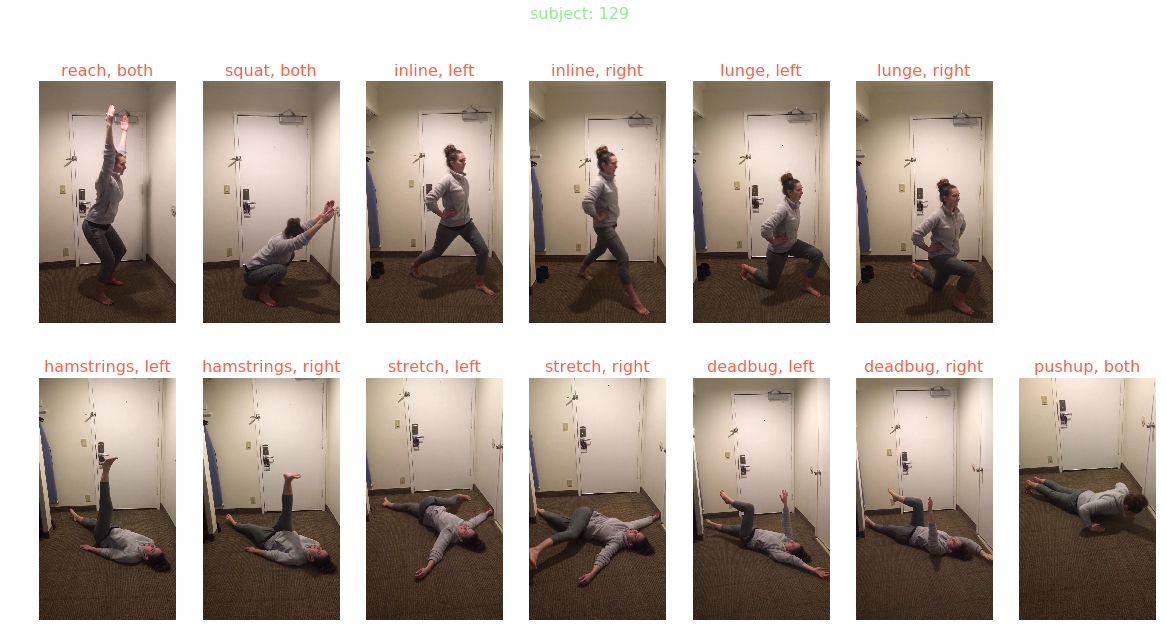

In [42]:
subjects_to_view_list = ['029','048','072','086','098','132','184','195','246']

#################################################################################################################################
# Begin: Main block of code that you need to modify.
#################################################################################################################################
N,label_type,side_type = get_all_label_combos(13)
subject_idx = ['129']*N  

# TODO: uncomment and modify the next set of lines for part 2
# N = 15
# label_type = ['squat']*N
# side_type = ['both']*N
# subject_idx = [None]*N # Change this to see different subjects

# TODO: you will need to change the plot_image and plot_keypoints flags for 2 (keypoints+images), and 3 (keypoints only)
plot_image = True       # TODO: change this for part 1, #3!
plot_keypoints = False  # TODO: change this for part 1, #2!
#################################################################################################################################
# End: Main block of code that you need to modify.
#################################################################################################################################

frames,subjects,labels,sides = get_N_random_key_frames(mds_dirs['root'],
                                                       N,
                                                       subject_idx=subject_idx,
                                                       label_type=label_type,
                                                       side_type=side_type)

# We'll title the plots differently depending on whether we have the same subject or not
same_subject = np.unique(subjects).shape[0] == 1

if plot_keypoints:
    colormap = get_labelbox_colormap()
    keypoints,_,_,_ = get_N_gt_keypoints(mds_dirs['root'],
                                     N,
                                     subject_idx=subjects,
                                     label_type=labels,
                                     side_type=sides)
# setup basic plot info
if N == 13:
    fig=plt.figure(figsize=(20, 10))
    num_rows = 2
    num_cols = 7
    # Keeps all standing key frames in the top row, and all ground key frames in the bottom row
    force_new_row = 5
elif N == 15:
    fig=plt.figure(figsize=(20, 20))
    num_rows = 3
    num_cols = 5
    force_new_row = 10000
else:
    raise ValueError('N can only be 13 or 15')

# Figure has one main title with the subject id if all images have the same subject id
if same_subject:
    fig.suptitle('subject: {}'.format(subject_idx[0]),fontsize=16,color='lightgreen')
    
# Now we finally get to plot the key frames and/or keypoints that we sampled. How fun!
for n in range(N):
    plt.subplot(num_rows, num_cols, n + 1 + (n>force_new_row))
    # Possible TODO: if imageio doesn't work for you, change this to something like opencv
    # to read the images. Note: if you use opencv, the default color channel ordering is 
    # not RGB, so you'll need to switch the color channels. Many tutorials with this info
    # exist online. If you're still confused, make a Piazza post.
    im = imageio.imread(frames[n])
    # Zero out the image if we aren't plotting key frames
    if not plot_image:
        im = im*0
    plt.imshow(im)
    
    if plot_keypoints:
        kps_n = keypoints[n]   # Get the keypoints for the current frame
        for k in kps_n.keys(): # Loop over the body joints
            for point in kps_n[k]: # Some people labeled multiple keypoints for the same body joint..
                if point['logits'] > 0: # Not every key frame is labeled. If a key frame is missing, its logits value is 0
                    plt.plot(point['x'],point['y'],'o',color=colormap[k],markeredgecolor='k',markeredgewidth=1.,markersize=7)
    
    # Makes the titling nicer. You could do something similar for the case where it is the same movement too.
    if same_subject:
        plt.title('{}, {}'.format(labels[n],sides[n]),fontsize=16,color='tomato')
    else:
        plt.title('subject: {}\n {}, {}'.format(subjects[n],labels[n],sides[n]),fontsize=16,color='tomato')
    plt.axis('off')
#plt.gcf().tight_layout()

# Video Frame visualizations

Now we will visualize some things about the other video frames in MDS189.

## Part 3: Same subject
For the subject `'129'`, visualize the following:
1. **Video frames + pseudo ground truth bounding boxes**: A random frame from each of the 8 movements, with OpenPose-based bounding box overlaid
2. **Video frames + pseudo ground truth pose**: Same as 1, but with OpenPose keypoints overlaid instead of the bounding box
3. **All frames for one movement**: Visualize the 15 video frames for `'squat'`

To get a sense of the OpenPose quality across subjects, repeat number 2 above, for at least 5 subjects in `subjects_to_view_list`

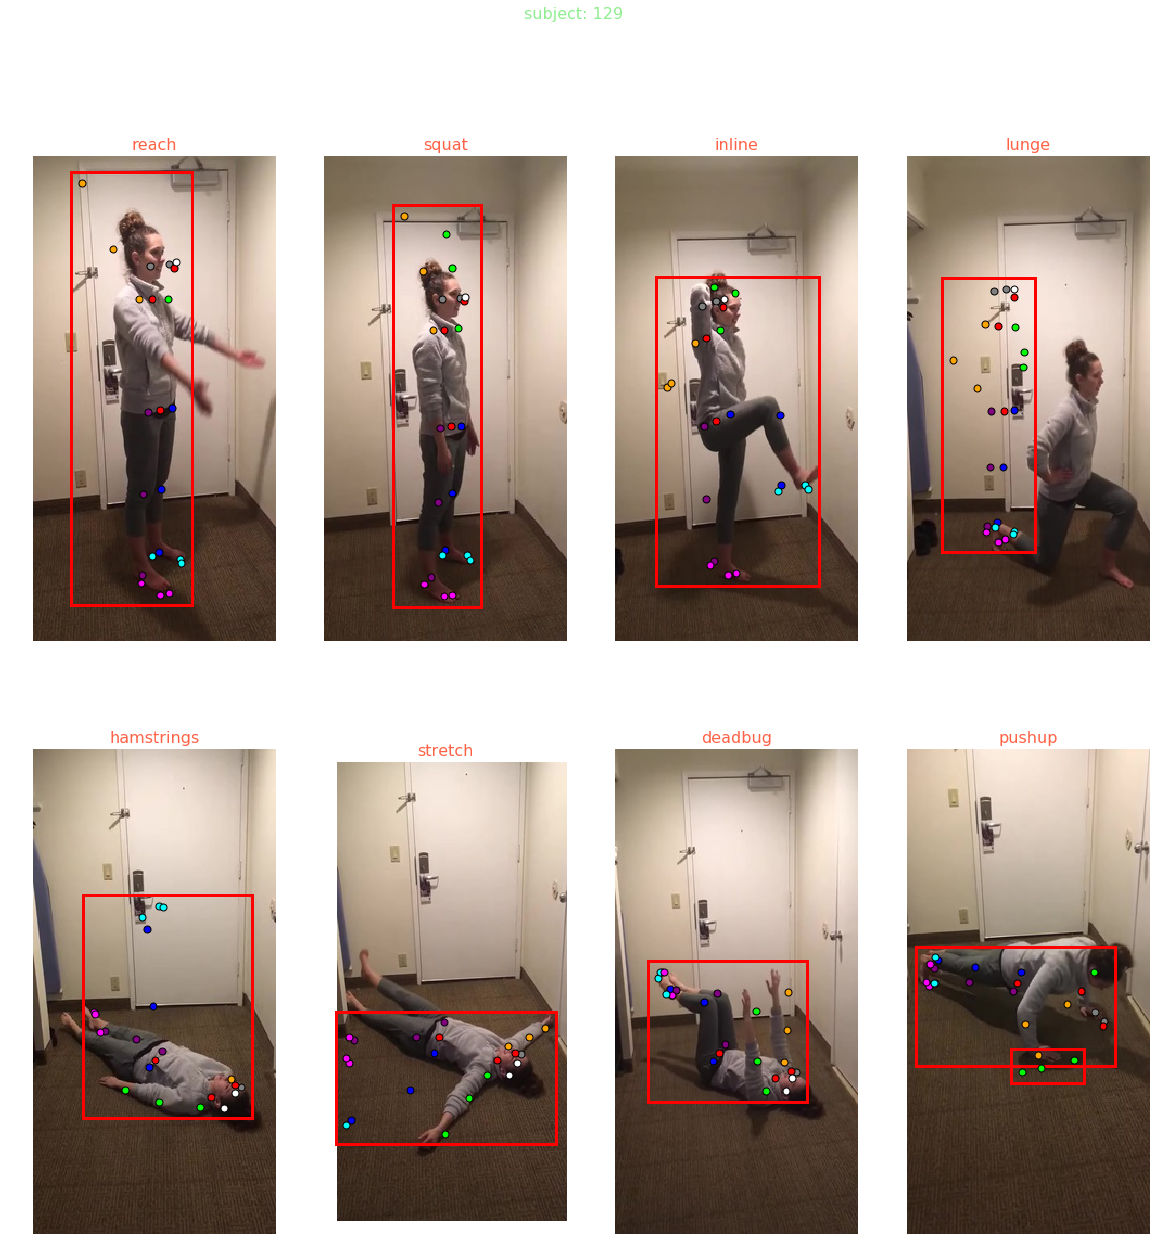

In [44]:
subjects_to_view_list = ['029','048','072','086','098','132','184','195','246']

#################################################################################################################################
# Begin: Main block of code that you need to modify.
#################################################################################################################################
N,label_type,side_type = get_all_label_combos(8)
subject_idx = ['129']*N
frame_idx = [None]*N # For part 1, #5, you'll need to change this to range(N)

# # TODO: uncomment and modify the next set of lines for part 2
# N = 15
# frame_idx = [None]*N
# label_type = [None]*N
# subject_idx = [None]*N # Change this to see different subjects

# TODO: you will need to change the plot_image and plot_keypoints flags for 2 (keypoints+images), and 3 (keypoints only)
plot_image = True       # TODO: change this for part 1, #4
plot_keypoints = True   # TODO: change this for part 1, #3
plot_bbox = True            # TODO: change this for part 1, #2
#################################################################################################################################
# End: Main block of code that you need to modify.
#################################################################################################################################

frames,frame_ids,subjects,labels = get_N_random_video_frames(mds_dirs['root'],
                                                             N,
                                                             subject_idx=subject_idx,
                                                             label_type=label_type,
                                                             frame_idx=frame_idx
                                                            )

# We'll title the plots differently depending on whether we have the same subject or not
same_subject = np.unique(subjects).shape[0] == 1

if plot_keypoints or plot_bbox:
    colormap = get_labelbox_colormap()
    keypoints,bboxes,scales,_,_ = get_N_OP_keypoints(mds_dirs['root'],
                                                     N,
                                                     subject_idx=subjects,
                                                     label_type=labels,
                                                     frame_idx=frame_ids
                                                    )
# setup basic plot info
if N == 13:
    fig=plt.figure(figsize=(20, 10))
    num_rows = 2
    num_cols = 7
    # Keeps all standing key frames in the top row, and all ground key frames in the bottom row
    force_new_row = 5
elif N == 8:
    fig=plt.figure(figsize=(20,20))
    num_rows = 2
    num_cols = 4
    force_new_row = 10000
elif N == 15:
    fig=plt.figure(figsize=(20, 20))
    num_rows = 3
    num_cols = 5
    force_new_row = 10000
else:
    raise ValueError('N can only be 13 or 15')

# Figure has one main title with the subject id if all images have the same subject id
if same_subject:
    fig.suptitle('subject: {}'.format(subject_idx[0]),fontsize=16,color='lightgreen')
    
# Now we finally get to plot the key frames and/or keypoints that we sampled. How fun!
for n in range(N):
    plt.subplot(num_rows, num_cols, n + 1 + (n>force_new_row))
    # Possible TODO: if imageio doesn't work for you, change this to something like opencv
    # to read the images. Note: if you use opencv, the default color channel ordering is 
    # not RGB, so you'll need to switch the color channels. Many tutorials with this info
    # exist online. If you're still confused, make a Piazza post.
    im = imageio.imread(frames[n])
    # Zero out the image if we aren't plotting key frames
    if not plot_image:
        im = im*0
    plt.imshow(im)
    
    if plot_bbox:
        for bb in bboxes[n]:
            rect = patches.Rectangle((bb[0]*scales[n][0]-10,bb[1]*scales[n][1]-10),
                                     (bb[2]-bb[0])*scales[n][0]+20,(bb[3]-bb[1])*scales[n][1]+20,
                                     linewidth=3,edgecolor='r',facecolor='none')
            ax = plt.gca()
            ax.add_patch(rect)
    
    if plot_keypoints:
        kps_n = keypoints[n]   # Get the keypoints for the current frame
        for kps_ni in kps_n:
            kps_ni_dict = get_openpose_dict(kps_ni)
            for k in kps_ni_dict.keys(): # Loop over the body joints
                point = kps_ni_dict[k]
                if point['logits'] > 0: # Not every key frame is labeled. If a key frame is missing, its logits value is 0
                    plt.plot(point['x']*scales[n][0],point['y']*scales[n][1],'o',
                             color=colormap[k],markeredgecolor='k',markeredgewidth=1.,markersize=7)
    
    # Makes the titling nicer. You could do something similar for the case where it is the same movement too.
    if same_subject:
        plt.title('{}'.format(labels[n]),fontsize=16,color='tomato')
    else:
        plt.title('subject: {}\n {}'.format(subjects[n],labels[n]),fontsize=16,color='tomato')
    plt.axis('off')
#plt.gcf().tight_layout()

# Neck keypoint visualization
Run the next cell to see the plot of the neck keypoint annotations (from labelbox)

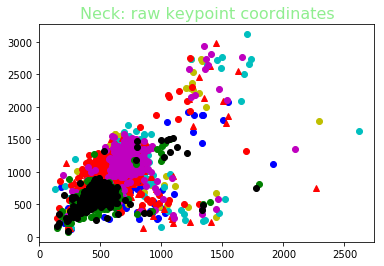

In [45]:
_,subject_list,_ = os.walk(mds_dirs['root']).next()
neck = {'reach':{'x':[],'y':[],'color':'ko'},
           'squat':{'x':[],'y':[],'color':'ro'},
           'inline':{'x':[],'y':[],'color':'go'},
           'lunge':{'x':[],'y':[],'color':'bo'},
           'hamstrings':{'x':[],'y':[],'color':'co'},
           'stretch':{'x':[],'y':[],'color':'mo'},
           'deadbug':{'x':[],'y':[],'color':'yo'},
           'pushup':{'x':[],'y':[],'color':'r^'},
          }
for id in subject_list:
    # get the neck coordinate
    for label in neck.keys():
        # load the label file
        data = read_json('{}/{}.json'.format(mds_dirs['labels'].format(id),label))
        x = []; y = []
        for si in ['left','right']:
            kps_si = data['gt_pose_dict'][si]['Neck']
            for kpi in kps_si:
                # take the keypoint coordinates only if this point was labeled
                if kpi['logits'] > 0:
                    x.append(kpi['x'])
                    y.append(kpi['y'])
        # average over all the left and right labels for the keypoint
        if len(x) > 0:
            x_ = np.mean(x)
            y_ = np.mean(y)
            neck[label]['x'].append(x_)
            neck[label]['y'].append(y_)

for label in neck.keys():
    plt.plot(neck[label]['x'],neck[label]['y'],neck[label]['color'])
    plt.title('Neck: raw keypoint coordinates',color='lightgreen',fontsize=16)

For each labeled key frame, we aligned the labeled pose with the labeled pose from Heather's corresponding key frame. The alignment is done using Procrustes analysis: https://en.wikipedia.org/wiki/Procrustes_analysis

Run the cell below to plot the (normalized) aligned Neck keypoint coordinates.

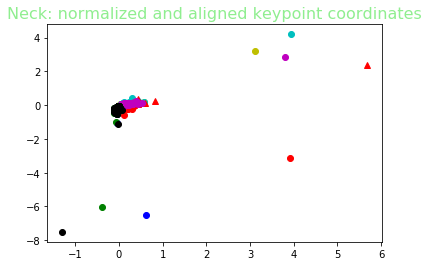

In [46]:
neck = {'reach':{'x':[],'y':[],'color':'ko'},
           'squat':{'x':[],'y':[],'color':'ro'},
           'inline':{'x':[],'y':[],'color':'go'},
           'lunge':{'x':[],'y':[],'color':'bo'},
           'hamstrings':{'x':[],'y':[],'color':'co'},
           'stretch':{'x':[],'y':[],'color':'mo'},
           'deadbug':{'x':[],'y':[],'color':'yo'},
           'pushup':{'x':[],'y':[],'color':'r^'},
          }
for id in subject_list:
    # get the neck coordinate
    for label in neck.keys():
        # load the label file
        data = read_json('{}/{}.json'.format(mds_dirs['labels'].format(id),label))
        aligned_dict = {'left':get_openpose_dict(data['gt_pose_align']['left']),
                        'right':get_openpose_dict(data['gt_pose_align']['right'])}
        x = []; y = []
        for si in ['left','right']:
            kps_si = aligned_dict[si]['Neck']
            if kps_si['logits'] > 0 and kps_si['x'] != 0 and kps_si['y'] != 0:
                x.append(kps_si['x'])
                y.append(kps_si['y'])
        if len(x) > 0:
            x_ = np.mean(x)
            y_ = np.mean(y)
            neck[label]['x'].append(x_)
            neck[label]['y'].append(y_)

for label in neck.keys():
    plt.plot(neck[label]['x'],neck[label]['y'],neck[label]['color'])
    plt.title('Neck: normalized and aligned keypoint coordinates',color='lightgreen',fontsize=16)